# Grid Mapping: From Occupancy Map to Semantic Map

## Binary Bayes Filters

Suppose a cell has a binary state that does not change over time, e.g. occupancy state, the belief of state can be described as:

$$
\begin{align}
bel_t(x) =& p(x| z_{1, \cdots, t})
\end{align}
$$

The state is chosen from two: $x$ and $\neg x$, where $bel_t(x) + bel_t(\neg x) = 1$.

### Recursive Estimation

$$
\begin{align}
bel_t(x) =& p(x| z_{1, \cdots, t}) \\
=& \frac{p(z_t | x, z_{1, \cdots, t-1})p(x|z_{1, \cdots, t-1})}{p(z_t | z_{1, \cdots, t-1})} \\
=& \frac{p(z_t | x)bel_{t-1}(x)}{p(z_t | z_{1, \cdots, t-1})} \\
bel_t(\neg x) =& p(\neg x| z_{1, \cdots, t}) \\
=& \frac{p(z_t | \neg x)bel_{t-1}(\neg x)}{p(z_t | z_{1, \cdots, t-1})} \\
\end{align}
$$

Then we can get:

$$
\begin{align}
\frac{bel_t(x)}{bel_t(\neg x)} =& \frac{p(z_t | x)bel_{t-1}(x)}{p(z_t | \neg x)bel_{t-1}(\neg x)}
\end{align}
$$

Normally, we will use log-based update:

$$
\begin{align}
ln(\frac{bel_t(x)}{bel_t(\neg x)}) =& ln(\frac{p(z_t | x)bel_{t-1}(x)}{p(z_t | \neg x)bel_{t-1}(\neg x)})\\
l_t =& l_{t-1} + ln(\frac{p(z_t | x)}{p(z_t | \neg x)})
\end{align}
$$
**where $bel_t(x) = 1 - \frac{1}{1+e^{l_t}}$**

We call $p(z_t | x)$ as **forward model** as it calculate the likelihood distribution. However, sometimes, it is hard to get the the likelihood distribution over distributions, e.g. measurement is an image. In such case, it is much easier to get the **inverse model**, aka $p(x | z_t$). Then we will have:

$$
\begin{align}
ln(\frac{bel_t(x)}{bel_t(\neg x)}) =& ln(\frac{p(z_t | x)bel_{t-1}(x)}{p(z_t | \neg x)bel_{t-1}(\neg x)})\\
l_t =& l_{t-1} + ln(\frac{p(x|z_t)p(\neg x_0)}{p(\neg x|z_t)p(x_0)}) \\
l_t =& l_{t-1} - l_0 + ln(\frac{p(x|z_t)}{1- p(x|z_t)})
\end{align}
$$

observations: ['occupied', 'empty', 'occupied', 'occupied', 'occupied', 'empty', 'occupied', 'empty', 'occupied', 'empty']


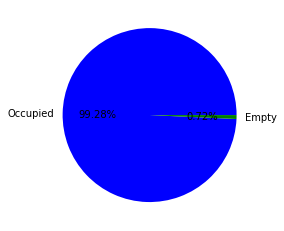

In [71]:
# Binary Bayes Filters with Recursive Estimation

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

labels = ['Occupied', 'Empty']
bel_0 = [0.5, 0.5]
assert(bel_0[0] + bel_0[1] == 1)
colors = ['b', 'g']

gt_state = 1 # occupied
# p(z=0 | gt_state = 1) = 0.3
# p(z=1 | gt_state = 1) = 0.7
probs = [0.3, 0.7]
data = []
npoints = 10
for e in np.random.uniform(0, 1, npoints):
    if e <= probs[0]:
        obs = 0
    else:
        obs = 1
    data.append(obs)

# Inverse model
# p(gt_state = 1 | z=0) = 0.3
# p(gt_state = 0 | z=0) = 0.7
# p(gt_state = 1 | z=1) = 0.8
# p(gt_state = 0 | z=1) = 0.2
l_0 = np.log(bel_0[0] / (1-bel_0[0]))

def l_to_bel(l):
    return 1 - 1.0/(1 + np.exp(l))

bels = []
l = l_0
for obs in data:
    if obs == 0:
        p = 0.3
    else:
        p = 0.8
    l = l - l_0 + np.log(p/(1-p))
    bels.append(l_to_bel(l))
data_str = ['occupied' if obs == 1 else 'empty' for obs in data]
print(f'observations: {data_str}')
stats = plt.pie([bels[-1], 1-bels[-1]], labels=labels, colors=colors, autopct='%1.2f%%')

#

### Beta Distribution as Conjugate Prior

[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is the conjugate prior for the Categorical distribution. For the binary case, Dirichlet distribution is a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).  We can track the posterior distribution use a Beta distribution.  

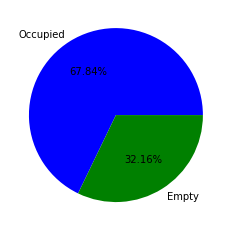

In [51]:
# Beta Distribution as Conjugate Prior

import numpy as np
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Occupied', 'Empty']
assert(bel_0[0] + bel_0[1] == 1)
colors = ['b', 'g']


gt_state = 1 # occupied
# p(z=0 | gt_state = 1) = 0.3
# p(z=1 | gt_state = 1) = 0.7
probs = [0.3, 0.7]
data = []
npoints = 1000
for e in np.random.uniform(0, 1, npoints):
    if e <= probs[0]:
        obs = 0
    else:
        obs = 1
    data.append(obs)

alpha_occu = 0
alpha_empty = 0


for obs in data:
    if obs == 0:
        alpha_empty += 1
    else:
        alpha_occu += 1
    alpha_sum = alpha_empty + alpha_occu
modes = [(alpha_occu - 1) / (alpha_sum - 2), (alpha_empty - 1) / (alpha_sum - 2)]

plt.subplots()
pie = plt.pie(modes, labels=labels, colors=colors, autopct='%1.2f%%')

#

## Occupancy Grid Map

Occupancy grid map is an idea that extends from a single cell to many cells and considers cell states are independent:

$$
p(m | z_{1:t}, x_{1:t}) = \prod p(m_i | z_{1:t}, x_{1:t})
$$

$$
\begin{align}
l_t =& l_{t-1} - l_0 + ln(\frac{p(m_i|z_t)}{1- p(m_i|z_t)})
\end{align}
$$

## Semantic Map

Occupancy grid map only consider binary states in a cell, whereas semantic map maintains a categorical distribution in a cell. 

### Recursive Estimation with Histogram Filters

For forward model:
$$
\begin{align}
bel_t(x) =& p(x| z_{1, \cdots, t}) \\
=& \frac{p(z_t | x, z_{1, \cdots, t-1})p(x|z_{1, \cdots, t-1})}{p(z_t | z_{1, \cdots, t-1})} \\
=& \frac{p(z_t | x)bel_{t-1}(x)}{p(z_t | z_{1, \cdots, t-1})} \\
\propto& p(z_t | x)bel_{t-1}(x) \\
\end{align}
$$

For inverse model:
$$
\begin{align}
bel_t(x) =& p(x| z_{1, \cdots, t}) \\
=& \frac{p(x| z_t)p(z_t)bel_{t-1}(x)}{p(z_t | z_{1, \cdots, t-1})p(x_0)} \\
\propto& \frac{p(x | z_t)bel_{t-1}(x)}{p(x)} \\
\end{align}
$$

Since state $x$ can take multiple values for semantic mapping, we will use a histogram to track the categorical distribution in a cell. The table below shows one example using forward model.

|        | state:r | state:g | state:b |
|--------|---------|---------|---------|
| obs: r | 0.7     | 0.1     | 0.1     |
| obs: g | 0.2     | 0.7     | 0.1     |
| obs: b | 0.1     | 0.2     | 0.8     |

GT: r:0.2, g:0.2, b:0.6
Observations: [2, 2, 0, 2, 1, 0, 1, 0, 2, 2]
Estimation: r:0.03, g:0.03, b:0.94


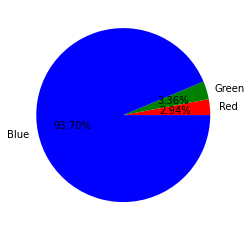

In [93]:
# Recursive Estimation with Histogram Filters

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Red', 'Green', 'Blue'
probs = [0.2, 0.2, 0.6]
colors = ['r', 'g', 'b']
print(f'GT: r:{probs[0]}, g:{probs[1]}, b:{probs[2]}')
data = []
r_cnt = 0
g_cnt = 0
b_cnt = 0
npoints = 10
for e in np.random.uniform(0, 1, npoints):
    if e <= probs[0]:
        obs = 0
    elif e <= probs[0] + probs[1]:
        obs = 1
    else:
        obs = 2
    data.append(obs)
    
bel_0 = [0.3, 0.3, 0.4] # prior
bel = bel_0

# Use forward model 
trans_matrix = np.array([
    [0.7, 0.1, 0.1],
    [0.2, 0.7, 0.1],
    [0.1, 0.2, 0.8]
])

for obs in data:
    trans_v = trans_matrix[obs, :]
    bel = np.multiply(bel, trans_v)
    bel = bel / np.sum(bel) # re-normalize
#

plt.subplots()
pie = plt.pie(bel, labels=labels, colors=colors, autopct='%1.2f%%')
print(f'Observations: {data}')
print(f'Estimation: r:{bel[0]:.2f}, g:{bel[1]:.2f}, b:{bel[2]:.2f}')

#

### Dirichlet Distribution as Conjugate Prior

[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is the conjugate prior for the Categorical distribution. The example below shows the MAP of the categorical distribution for a single cell.

GT: r:0.2, g:0.3, b:0.5
Estimation: r:0.20, g:0.30, b:0.50


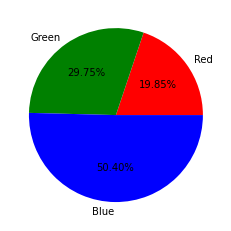

In [55]:
# Semantic mapping for single cell

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Red', 'Green', 'Blue'
probs = [0.2, 0.3, 0.5]
colors = ['r', 'g', 'b']

#plt.subplot()
#pie = plt.pie(probs, labels=labels, colors=colors, autopct='%1.2f%%')
#plt.title('GT class distribution')
#plt.axis('equal')  
print(f'GT: r:{probs[0]}, g:{probs[1]}, b:{probs[2]}')
data = []
r_cnt = 0
g_cnt = 0
b_cnt = 0
for e in np.random.uniform(0, 1, 10000):
    if e <= probs[0]:
        obs = 'r'
    elif e <= probs[0] + probs[1]:
        obs = 'g'
    else:
        obs = 'b'
    data.append(obs)


alpha_r = 2
alpha_g = 4
alpha_b = 4
alpha = (alpha_r, alpha_g, alpha_b)


for elem in data:
    if elem == 'r':
        alpha_r += 1
    elif elem == 'g':
        alpha_g += 1
    elif elem == 'b':
        alpha_b += 1
    alpha_sum = alpha_r + alpha_g + alpha_b
    modes = [(alpha_r - 1) / (alpha_sum - 3), (alpha_g - 1) / (alpha_sum - 3), (alpha_b - 1) / (alpha_sum - 3)]

plt.subplots()
pie = plt.pie(modes, labels=labels, colors=colors, autopct='%1.2f%%')

print(f'Estimation: r:{modes[0]:.2f}, g:{modes[1]:.2f}, b:{modes[2]:.2f}')

#

The example below shows the MAP of the categorical distribution for lane estimation.

(70, 100, 3)


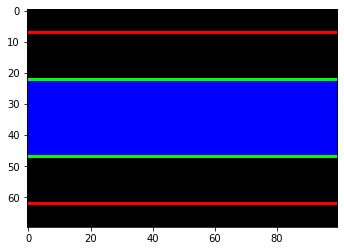

In [56]:
# Grid based semantic mapping, suppose we have a grid map 20mx14m(WxH, res:0.2m)

%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time

res = 0.2
W_m = 20
H_m = 14
W = int(W_m / res)
H = int(H_m / res)
gt_im = np.zeros((H, W, 3))
# --> x, W
# |
# |
# y
# H
#gt_im[1, 3, 0] = 1. # red
#gt_im[3, 1, 1] = 1. # green
#gt_im[3, 3, 2] = 1. # blue

# boundaries at y = 1.5, 12.5
# lane lines at y = 4.5, 9.5 
b_l_y = 1.5
b_r_y = 12.5
line_l_y = 4.5
line_r_y = 9.5
print(gt_im.shape)
gt_im[int(b_l_y/res), :, 0] = 1 # red bounadry
gt_im[int(b_r_y/res), :, 0] = 1
gt_im[int(line_l_y/res), :, 1] = 1 # green line
gt_im[int(line_r_y/res), :, 1] = 1
gt_im[int(line_l_y/res)+1 : int(line_r_y/res), :, 2] = 1 # blue lane

plt.imshow(gt_im)

#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Aggregated observations


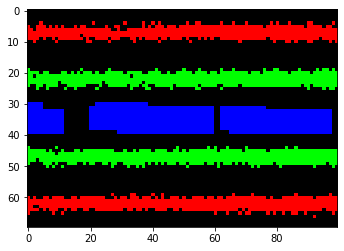

In [58]:
# Generate simulated observations

max_runs = 20
r = 0
g = 1
b = 2
car_L_h = 1.5
car_W_h = 0.75
def clip_x(xs):
    #if isinstance(xs, list) or isinstance(xs, (np.ndarray, np.generic)):
    #    return np.clip([int(x) for x in xs], 0, W-1)
    return np.clip(int(xs), 0, W-1)
def clip_y(ys):
    #if isinstance(ys, list) or isinstance(ys, (np.ndarray, np.generic)):
    #    return np.clip([int(y) for y in ys], 0, H-1)
    return np.clip(int(ys), 0, H-1)

obs_im = np.zeros((H, W, 3))
b_x_n = 0.1
b_y_n = 0.2
l_x_n = 0.1
k_y_n = 0.2
sample_dist = 0.1
obs_blind_range = 0

for i in range(max_runs):
    # print(f'iter: {i}')
    car_x = np.random.uniform(-10, W_m)
    car_y = np.random.uniform(H_m/2-0.25, H_m/2+0.25)
    # print(f'car at: ({car_x, car_y})')
    # TODO: orientation
    start_x = clip_x((car_x-car_L_h)/res)
    end_x = clip_x((car_x+car_L_h)/res)
    x_indices = range(start_x, end_x)
    start_y = clip_y((car_y-car_W_h)/res)
    end_y = clip_y((car_y+car_W_h)/res+1)
    y_indices = range(start_y, end_y)
    if start_x != end_x and start_y != end_y:
        yv, xv = np.meshgrid(y_indices, x_indices, indexing='ij')
        obs_im[yv, xv, b] += 1
    # Get boundary and lane line detections
    # step 1: sample points
    sampled_points = np.arange(car_x + car_L_h + obs_blind_range, W_m, sample_dist)
    for p in sampled_points:
        # line
        p_x = p+np.random.normal(0, l_x_n)
        p_y = line_l_y+np.random.normal(0, b_y_n)     
        obs_im[clip_y(p_y/res), clip_x(p_x/res), g] += 1
        
        p_x = p+np.random.normal(0, l_x_n)
        p_y = line_r_y+np.random.normal(0, b_y_n)     
        obs_im[clip_y(p_y/res), clip_x(p_x/res), g] += 1
        
        # boundary
        p_x = p+np.random.normal(0, b_x_n)
        p_y = b_l_y+np.random.normal(0, b_y_n)     
        obs_im[clip_y(p_y/res), clip_x(p_x/res), r] += 1
        
        p_x = p+np.random.normal(0, b_x_n)
        p_y = b_r_y+np.random.normal(0, b_y_n)     
        obs_im[clip_y(p_y/res), clip_x(p_x/res), r] += 1

#obs_im /= max_runs
print('Aggregated observations')
plt.imshow(obs_im)

#

Segmentation map without kernel smoothing


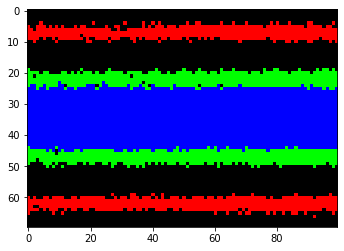

In [63]:
# Mapping using Dirichlet as Conjugate Prior

grid_alpha_c = np.full((H, W, 4), (1.0, 1.0, 1.0, 1.0)) # if prior is less than 1, there will be a problem. 
for y in range(H):
    for x in range(W):   
        obs = obs_im[y, x, :]
        grid_alpha_c[y, x, 0] += obs[0]
        grid_alpha_c[y, x, 1] += obs[1] 
        grid_alpha_c[y, x, 2] += obs[2]
        grid_alpha_c[y, x, 3] += max_runs - np.sum(obs)
        
pred_im = np.zeros((H, W, 3))
for y in range(H):
    for x in range(W):
        r = grid_alpha_c[y, x, 0]
        g = grid_alpha_c[y, x, 1]
        b = grid_alpha_c[y, x, 2]
        u = grid_alpha_c[y, x, 3]
        #total = r + g + b + u
        #pred_im[y, x, 0] = (r-1) / (total-4)
        #pred_im[y, x, 1] = (g-1) / (total-4)
        #pred_im[y, x, 2] = (b-1) / (total-4)
        total = r + g + b
        if (total <= 3):
            continue;
        pred_im[y, x, 0] = (r-1) / (total-3)
        pred_im[y, x, 1] = (g-1) / (total-3)
        pred_im[y, x, 2] = (b-1) / (total-3)

pred_im_no_kernel = pred_im

def hacky_region_growing(pred_im):
    for col in range(W):
        last_pixel_l_line = -1
        first_pixel_r_line = -1
        for row in range(H):
            if row < H / 2 and pred_im[row, col, 1] > 0:
                last_pixel_l_line = row
            if row > H / 2 and pred_im[row, col, 1] > 0:
                first_pixel_r_line = row
                break
        if last_pixel_l_line != -1 and first_pixel_r_line != -1:
            pred_im[last_pixel_l_line+1:first_pixel_r_line, col, 2] = 1
    return pred_im

pred_im_no_kernel = hacky_region_growing(pred_im)
plt.imshow(pred_im_no_kernel)
print('Segmentation map without kernel smoothing')

#

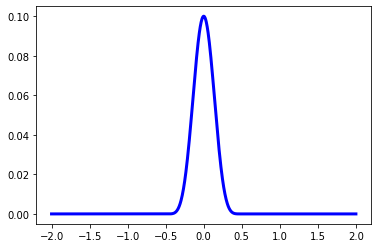

In [60]:
# A Sparse kernels

import math
def kernel_xy(x, y, l):
    d = math.sqrt((x[0]-y[0]) ** 2 +  (x[1]-y[1]) ** 2)
    return kernel(d, l)

def kernel(d, l):
    s = 0.1    
    ret = s * ((2+np.cos(2*math.pi*d/l))/3.0 * (1-d/l)  +  np.sin(2*math.pi*d/l)/(2*math.pi))
    ret[d >= l] = 0
    return ret

x_range = np.linspace(-2, 2, 1000)
y = kernel(np.abs(x_range), 0.5)
plt.subplots()
plt.plot(x_range, y, linewidth=3, color='b')
plt.show()

#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Segmentation map with sparse kernel smoothing


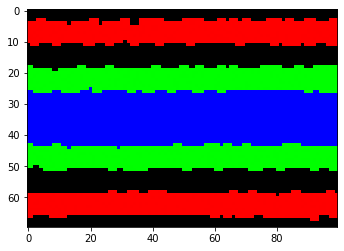

In [62]:
# Segmentation map with kernel smoothing

grid_alpha_c = np.full((H, W, 4), (1.0, 1.0, 1.0, 1.0))
l = 0.3
l_in_pixel = int(l / res)
for y in range(H):
    for x in range(W):
        for j in range(-l_in_pixel, l_in_pixel+1):
            for i in range(-l_in_pixel, l_in_pixel+1):
                yj = y + j
                xi = x + i
                if 0 <= yj and yj < H and 0 <= xi and xi < W:
                    obs = obs_im[yj, xi, :]
                    kernel_dist = kernel(np.array([math.sqrt((i*res)**2 + (j*res)**2)]), l)
                    grid_alpha_c[y, x, 0] += kernel_dist * obs[0]
                    grid_alpha_c[y, x, 1] += kernel_dist * obs[1]
                    grid_alpha_c[y, x, 2] += kernel_dist * obs[2]
                    grid_alpha_c[y, x, 3] += kernel_dist * (max_runs - np.sum(obs))
        
pred_im = np.zeros((H, W, 3))
for y in range(H):
    for x in range(W):
        r = grid_alpha_c[y, x, 0]
        g = grid_alpha_c[y, x, 1]
        b = grid_alpha_c[y, x, 2]
        u = grid_alpha_c[y, x, 3]
        #total = r + g + b + u
        #pred_im[y, x, 0] = (r-1) / (total-4)
        #pred_im[y, x, 1] = (g-1) / (total-4)
        #pred_im[y, x, 2] = (b-1) / (total-4)
        total = r + g + b
        if (total <= 3):
            continue;
        pred_im[y, x, 0] = (r-1) / (total-3)
        pred_im[y, x, 1] = (g-1) / (total-3)
        pred_im[y, x, 2] = (b-1) / (total-3)
plt.imshow(hacky_region_growing(pred_im))
print('Segmentation map with sparse kernel smoothing')

#

Reference:
- Lu, `Bayesian Spatial Kernel Smoothing for Scalable Dense Semantic Mapping`
- Thrun, `Probabilistic Robotics`
- Tu, `The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference`